<a href="https://colab.research.google.com/github/maetthil/NASASpaceApps/blob/main/Read_CDF_Files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install cdflib
!pip install spacepy

In [35]:
import cdflib 
import sys
import os
import requests
import pytz
import datetime
import pandas as pd
from bs4 import BeautifulSoup as bs
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [7]:
def download_bwt_file(year='2022'):
    url = f'https://cdaweb.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/{year}/'
    content = requests.get(url).content
    DATA_FOLDER = 'dataset/'
    if not os.path.exists(DATA_FOLDER):
        os.mkdir(DATA_FOLDER)
    links = bs(content).findAll('a', href=True)
    print (f'Baixando arquivos de dados de {year}')
    for link in tqdm(links):
        filename = link['href']
        if filename.find('.cdf') < 0:
            continue
        response = requests.get(f'{url}{filename}')
        with open(f'{DATA_FOLDER}{filename}', 'wb') as f:
            f.write(response.content)

In [8]:
download_bwt_file()

Baixando arquivos de dados de 2022


  0%|          | 0/264 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [9]:
data_cdf = cdflib.CDF("/content/dataset/wi_h2_mfi_20220104_v04.cdf")

In [14]:
print(data_cdf)

In [39]:
# Verifica quais são as variaveis dentro do arquivo
data_info = data_cdf.cdf_info()
# data_info

In [22]:
# Nesse caso queremos o campo magnético, B. Eles oferem nas coordenadas GSM, e GSE
# Acredito que para essa aplicação pode ser a GSM mesmo nesse momento

magnetic_field_gsm = data_cdf.varget("BGSM")
# São tres colunas, x, y e z
magnetic_field_gsm.shape

(937849, 3)

In [34]:
mag_field_dataframe = pd.DataFrame(magnetic_field_gsm, columns=["Bx_GSM", "Gy_GSM", "Bz_GSM"])

time = data_cdf.varget("Epoch")
mag_field_dataframe["Epoch"] = time

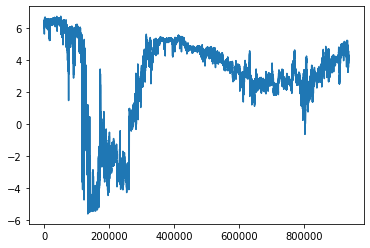

In [38]:
mag_field_dataframe["Gy_GSM"].plot()